In [1]:
# the point here is to get some idea of how unjammed the cultures are using PIV.

# takes a folder of whole videos, cropped and outsides set to zero, and applies piv to ch1.

# spits out:
# tifs of the graph of piv vectors overlayed over frame 1.
# tifs of a graph of vector size.
# a csv of the fractional area with speed > some threshold, median speed, and spytub fraction above some threshold


In [2]:
#packages
import os # navigating file system
import numpy as np # numbers
import pandas as pd # for dataframe handling
from skimage import io # for saving tifs
from openpiv import tools, pyprocess, validation, filters, scaling # the meat
import matplotlib.pyplot as plt   # for plotting everything
from matplotlib import cm, colors # for letting us do specific things with colors in plots

# for some reason openpiv does not install correctly so i need to define this function here!
# perhaps there is a better solution but now is not the time!
# this is just copied and pasted from filters.py in the openpiv github repo
# copied 5/30/2024 @ 10:10 pm cst.
from typing import Tuple, Optional
import numpy as np
import numpy.typing as npt
from scipy.signal import convolve
from openpiv.lib import replace_nans
def replace_outliers(
    u: np.ndarray,
    v: np.ndarray,
    flags: np.ndarray,
    w: Optional[np.ndarray]=None,
    method: str="localmean",
    max_iter: int=5,
    tol: float=1e-3,
    kernel_size: int=1,
    )-> Tuple[np.ndarray, ...]:
    
    # we shall now replace NaNs only at flags positions,
    # regardless the grid_mask (which is a user-provided masked region)

    
    if not isinstance(u, np.ma.MaskedArray):
        u = np.ma.masked_array(u, mask=np.ma.nomask)
        
    # store grid_mask for reinforcement
    grid_mask = u.mask.copy()

    u[flags] = np.nan
    v[flags] = np.nan
    
    uf = replace_nans(
        u, method=method, max_iter=max_iter, tol=tol,
        kernel_size=kernel_size
    )
    vf = replace_nans(
        v, method=method, max_iter=max_iter, tol=tol,
        kernel_size=kernel_size
    )

 
    uf = np.ma.masked_array(uf, mask=grid_mask)
    vf = np.ma.masked_array(vf, mask=grid_mask)

    if isinstance(w, np.ndarray):
        w[flags] = np.nan
        wf = replace_nans(
            w, method=method, max_iter=max_iter, tol=tol,
            kernel_size=kernel_size
        )
        wf = np.ma.masked_array(wf, mask=grid_mask)
        return uf, vf, wf
    
    return uf, vf

In [3]:
def pivit(folder, window_size=128, search_size=160, overlap=100,
         um_per_pixel=1.601, interval=2, frame1=4, frame2=6, flow_mag_threshold=180, sig2noise_threshold=1.05):
        
    # get list of files to process
    tbd = os.listdir(folder)
    
    # create processed folder if it doesn't already exist
    processed_folder = os.path.join(folder, 'piv')
    os.makedirs(processed_folder, exist_ok=True)

    
    #make a list to store concatenated values
    statistics = []
    
    for x in range(len(tbd)):
        current = tbd[x]
        if os.path.isfile(os.path.join(folder, current)):
            print('Now on:' + str(current))
            image = io.imread(os.path.join(folder, current)).astype('uint16')
            interest = image[:, :, :, 0]

            # perform the piv
            u0, v0, sig2noise = pyprocess.extended_search_area_piv(interest[frame1].astype(np.int32), interest[frame2].astype(np.int32), 
                                                                   window_size = window_size, overlap = overlap, 
                                                                   search_area_size = search_size, 
                                                                   sig2noise_method = 'peak2peak', use_vectorized=True)

            # x and y coords for each vector
            x, y = pyprocess.get_coordinates(image_size=interest[frame1].shape, search_area_size = search_size, overlap = overlap)
            print('piv done, now filtering')
            # get rid of the vectors not over the culture
            mask = interest[frame1].astype('bool') # this works bc im manually clearing area outside the culture (setting to zero)
            in_mask_flag = []
            # loop through each x and y point to see if it's in the mask and append True/False as appropriate
            for (xpt,ypt) in zip(x.flatten(),y.flatten()):
                if mask[int(ypt),int(xpt)] == True:
                    in_mask_flag.append(True)
                else:
                    in_mask_flag.append(False)
            # reshape the list so it matches the other arrays
            in_mask_flag = np.reshape(in_mask_flag, x.shape)

            # calculate the flow magnitude for each point
            flow_mag = np.sqrt(u0**2 + v0**2)

            # get rid of what's moving too fast
            magnitude_flags = flow_mag > flow_mag_threshold
            u2, v2 = replace_outliers(u=u0, v=v0,
                                       flags=magnitude_flags,
                                       method='localmean',
                                       max_iter=3,
                                       kernel_size=1)

            # get rid of what has too low signal to noise
            sig2noise_flags = sig2noise < sig2noise_threshold
            u3, v3 = replace_outliers(u = u2, v = v2,
                                       flags = sig2noise_flags,
                                       method='localmean',
                                       max_iter=3,
                                       kernel_size=3)
            print('filter is done, now plotting')
            new_flow_mag = np.sqrt(u3**2 + v3**2)
            # now convert the flow_magnitudes to the correct units
            flow_magnitudes = new_flow_mag[in_mask_flag] * um_per_pixel / interval * (frame2 - frame1)
            # get rid of anything that is not a number (NaN)
            flow_magnitudes = flow_magnitudes[~np.isnan(flow_magnitudes)]

            # SAVE PLOTS: plot o vectors overlayed
            plt.figure(figsize=(10,10))
            plt.imshow(interest[frame1], cmap='Greys', vmin = 0, vmax = 1500)
            plt.quiver(x[in_mask_flag], y[in_mask_flag], u0[in_mask_flag], -v0[in_mask_flag], color='red', scale = 1000)
            plt.axis('off')
            plt.savefig(os.path.join(processed_folder, current[:-4] + '_flow_overlay.tif'), format='tiff')
            plt.close()

            # save a nice lil violin plot
            plt.figure()
            plt.violinplot(flow_magnitudes)
            plt.title('Flow Speed (µm/h)')
            plt.savefig(os.path.join(processed_folder, current[:-4] + '_flow_dist.tif'), format='tiff')

            # save array: flow_magnitudes
 
            flow_magnitudes_vis = new_flow_mag * um_per_pixel / (interval * (frame2 - frame1)) * in_mask_flag
            plt.imshow(flow_magnitudes_vis, cmap='Greys', vmin = 0, vmax = 120)
            plt.savefig(os.path.join(processed_folder, current[:-4] + '_flowmags.tif'), format='tiff')
            print('done plotting and saving mags as tif. now working on the csv')
            # and write to csv: fxn >3um, fxn > 6 um, fxn > 12 um, fxn > 24 um, fxn > 48 um; mean speed, median speed.
            threshold_values = [-1, 3, 6, 12, 24, 48]
            counts = [np.sum(flow_magnitudes > th) for th in threshold_values]
            median_speed = np.median(flow_magnitudes)
            avg_speed = np.mean(flow_magnitudes)
            statistics.append([current, *counts, avg_speed, median_speed])
        else:
            print(f'Skipping: {current}')
     # write accumulated statistics to a CSV file for this folder
    print('finished all the files, joining into csv')
    csv_filename = os.path.join(processed_folder,  'flowmags_stats.csv')
    with open(csv_filename, 'w') as f:
        f.write('source, total, fxn.3, fxn.6, fxn.12, fxn.24, fxn.48, mean.speed, median.speed\n')
        for stats in statistics:
            f.write(','.join(map(str, stats)) + '\n')
    return

Now on:continual2_pt01_aligned_cropped.tif
Found 3378 bad peak(s)
we done pivved it, now filtering
filter is done, now plotting


C:\Users\Mark\anaconda3\envs\spyin\lib\site-packages\numpy\lib\function_base.py:4691: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
C:\Users\Mark\anaconda3\envs\spyin\lib\site-packages\numpy\core\fromnumeric.py:758: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


done plotting and saving mags as tif. now working on the csv
Now on:continual2_pt02_aligned_cropped.tif
Found 2725 bad peak(s)
we done pivved it, now filtering
filter is done, now plotting
done plotting and saving mags as tif. now working on the csv
Now on:continual2_pt03_aligned_cropped.tif
Found 2726 bad peak(s)
we done pivved it, now filtering
filter is done, now plotting
done plotting and saving mags as tif. now working on the csv
Now on:continual2_pt04_aligned_cropped.tif
Found 2828 bad peak(s)
Found 2 negative correlation indices resulting in NaNs
Fallback for negative indices is a 3 point parabolic curve method


C:\Users\Mark\anaconda3\envs\spyin\lib\site-packages\openpiv\pyprocess.py:1150: RuntimeWarning: invalid value encountered in log
  nom1 = log(cl) - log(cr)
C:\Users\Mark\anaconda3\envs\spyin\lib\site-packages\openpiv\pyprocess.py:1151: RuntimeWarning: invalid value encountered in log
  den1 = 2 * log(cl) - 4 * log(c) + 2 * log(cr)
C:\Users\Mark\anaconda3\envs\spyin\lib\site-packages\openpiv\pyprocess.py:1152: RuntimeWarning: invalid value encountered in log
  nom2 = log(cd) - log(cu)
C:\Users\Mark\anaconda3\envs\spyin\lib\site-packages\openpiv\pyprocess.py:1153: RuntimeWarning: invalid value encountered in log
  den2 = 2 * log(cd) - 4 * log(c) + 2 * log(cu)


we done pivved it, now filtering
filter is done, now plotting
done plotting and saving mags as tif. now working on the csv
Now on:continual2_pt05_aligned_cropped.tif
Found 2608 bad peak(s)
we done pivved it, now filtering
filter is done, now plotting
done plotting and saving mags as tif. now working on the csv
Now on:continual2_pt06_aligned_cropped.tif
Found 3088 bad peak(s)
we done pivved it, now filtering
filter is done, now plotting
done plotting and saving mags as tif. now working on the csv
Now on:continual2_pt07_aligned_cropped.tif
Found 2872 bad peak(s)
we done pivved it, now filtering
filter is done, now plotting
done plotting and saving mags as tif. now working on the csv
Now on:continual2_pt08_aligned_cropped.tif
Found 1279 bad peak(s)
we done pivved it, now filtering
filter is done, now plotting
done plotting and saving mags as tif. now working on the csv
Now on:continual2_pt09_aligned_cropped.tif
Found 2527 bad peak(s)
we done pivved it, now filtering
filter is done, now pl

C:\Users\Mark\AppData\Local\Temp\ipykernel_22044\1262655996.py:69: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(10,10))
C:\Users\Mark\AppData\Local\Temp\ipykernel_22044\1262655996.py:77: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


done plotting and saving mags as tif. now working on the csv
Now on:longcilia2_pt10_aligned_cropped.tif
Found 2771 bad peak(s)
Found 1 negative correlation indices resulting in NaNs
Fallback for negative indices is a 3 point parabolic curve method
we done pivved it, now filtering
filter is done, now plotting
done plotting and saving mags as tif. now working on the csv
finished all the files, im joinin into csv
Now on:multitest_pt1_concat_aligned_cropped.tif
Found 3441 bad peak(s)
Found 1 negative correlation indices resulting in NaNs
Fallback for negative indices is a 3 point parabolic curve method
we done pivved it, now filtering
filter is done, now plotting
done plotting and saving mags as tif. now working on the csv
Now on:multitest_pt2_concat_aligned_cropped.tif
Found 2792 bad peak(s)
we done pivved it, now filtering
filter is done, now plotting
done plotting and saving mags as tif. now working on the csv
Now on:multitest_pt3_concat_aligned_cropped.tif
Found 2497 bad peak(s)
we don

filter is done, now plotting
done plotting and saving mags as tif. now working on the csv
Now on:mb_longcilia_pt08_aligned_cropped.tif
Found 3286 bad peak(s)
Found 1 negative correlation indices resulting in NaNs
Fallback for negative indices is a 3 point parabolic curve method
we done pivved it, now filtering
filter is done, now plotting
done plotting and saving mags as tif. now working on the csv
Now on:mb_longcilia_pt09_aligned_cropped.tif
Found 2767 bad peak(s)
Found 1 negative correlation indices resulting in NaNs
Fallback for negative indices is a 3 point parabolic curve method
we done pivved it, now filtering
filter is done, now plotting
done plotting and saving mags as tif. now working on the csv
Now on:mb_longcilia_pt10_aligned_cropped.tif
Found 2649 bad peak(s)
we done pivved it, now filtering
filter is done, now plotting
done plotting and saving mags as tif. now working on the csv
Now on:mb_longcilia_pt11_aligned_cropped.tif
Found 2561 bad peak(s)
we done pivved it, now filt

Found 2947 bad peak(s)
we done pivved it, now filtering
filter is done, now plotting
done plotting and saving mags as tif. now working on the csv
Now on:mb_d5d6_pt3_concat_aligned_cropped.tif
Found 2293 bad peak(s)
we done pivved it, now filtering
filter is done, now plotting
done plotting and saving mags as tif. now working on the csv
Now on:mb_d5d6_pt4_concat_aligned_cropped.tif
Found 2673 bad peak(s)
we done pivved it, now filtering
filter is done, now plotting
done plotting and saving mags as tif. now working on the csv
Now on:mb_d5d6_pt5_concat_aligned_cropped.tif
Found 2708 bad peak(s)
Found 1 negative correlation indices resulting in NaNs
Fallback for negative indices is a 3 point parabolic curve method
we done pivved it, now filtering
filter is done, now plotting
done plotting and saving mags as tif. now working on the csv
Now on:mb_d5d6_pt6_concat_aligned_cropped.tif
Found 2786 bad peak(s)
we done pivved it, now filtering
filter is done, now plotting
done plotting and saving m

Found 2327 bad peak(s)
we done pivved it, now filtering
filter is done, now plotting
done plotting and saving mags as tif. now working on the csv
finished all the files, im joinin into csv
Now on:Aligned_MAX_d3ag2_pt1_concat_cropped.tif
Found 3379 bad peak(s)
Found 1 negative correlation indices resulting in NaNs
Fallback for negative indices is a 3 point parabolic curve method
we done pivved it, now filtering
filter is done, now plotting
done plotting and saving mags as tif. now working on the csv
Now on:Aligned_MAX_d3ag2_pt2_concat_cropped.tif
Found 2695 bad peak(s)
we done pivved it, now filtering
filter is done, now plotting
done plotting and saving mags as tif. now working on the csv
Now on:Aligned_MAX_d3ag2_pt3_concat_cropped.tif
Found 3377 bad peak(s)
Found 2 negative correlation indices resulting in NaNs
Fallback for negative indices is a 3 point parabolic curve method
we done pivved it, now filtering
filter is done, now plotting
done plotting and saving mags as tif. now workin

ValueError: Could not find a backend to open `D:/0_all_whole/spynuc/ciliako44/ciliako44_pt02_aligned_cropped_attrack.xml`` with iomode `ri`.

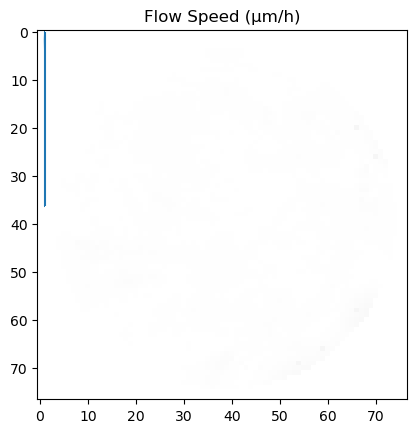

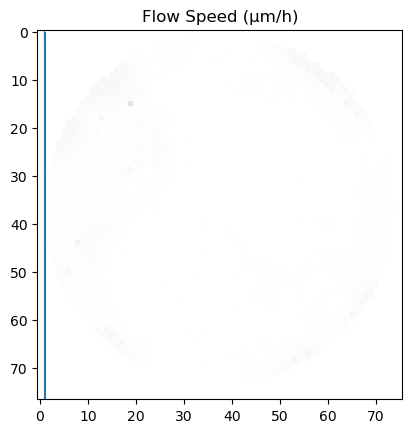

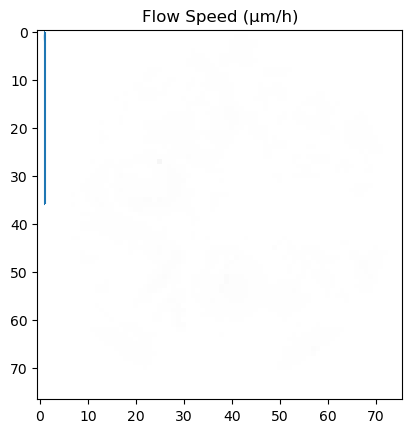

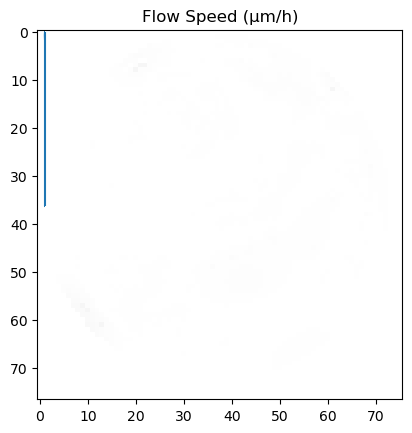

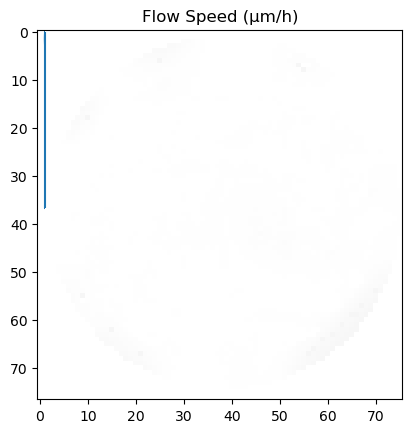

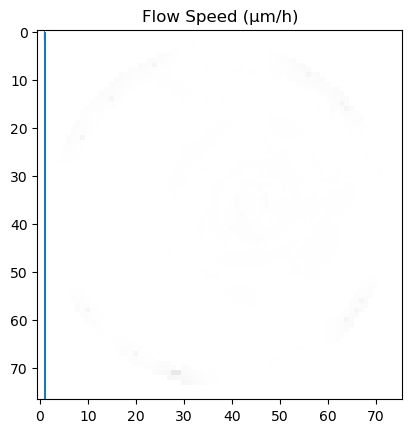

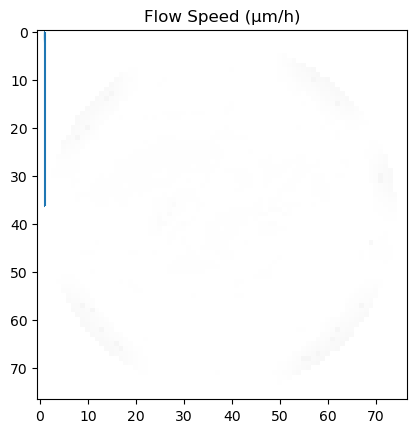

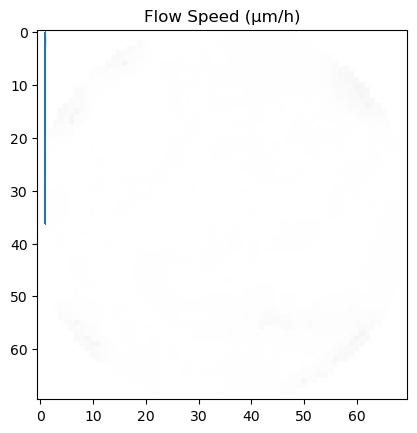

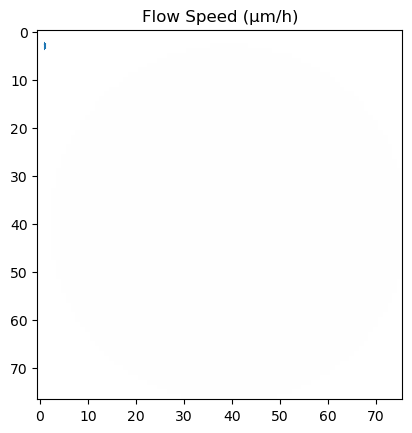

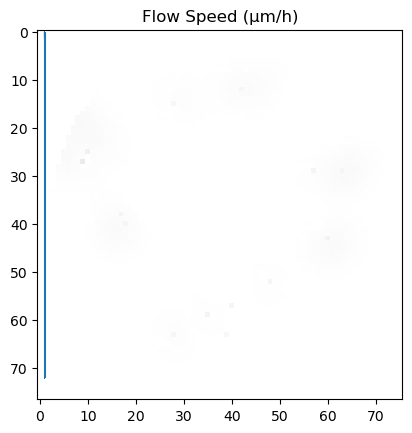

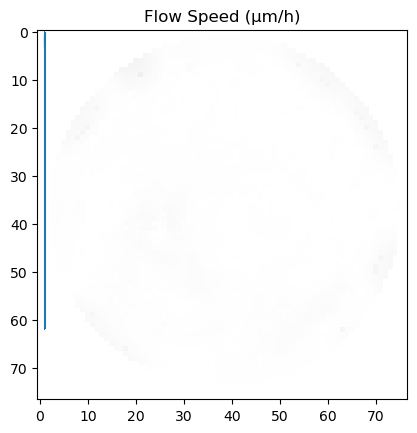

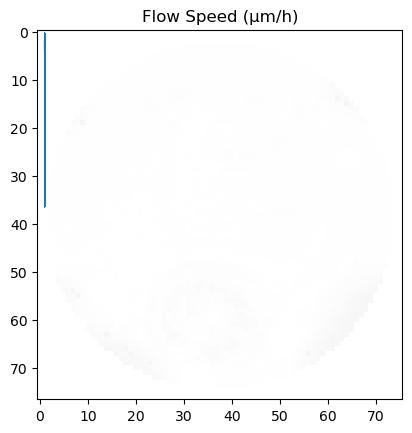

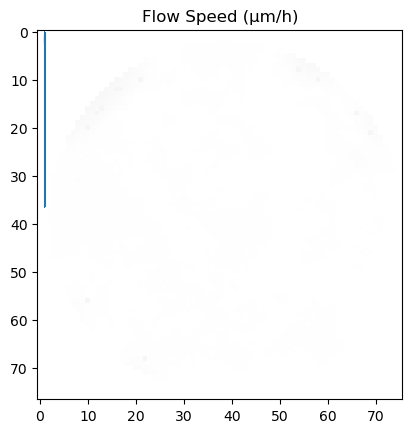

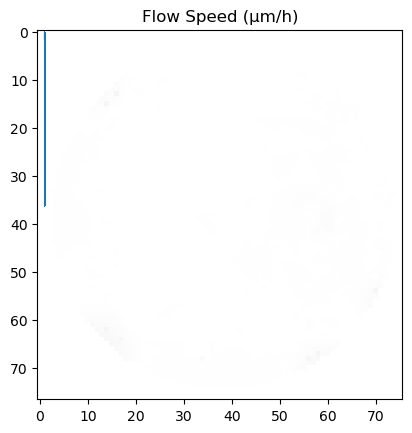

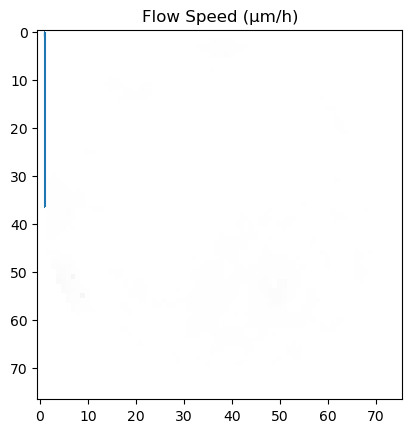

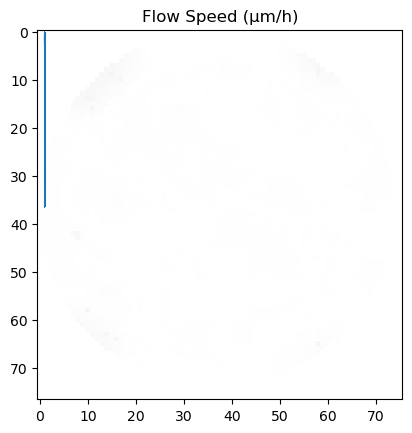

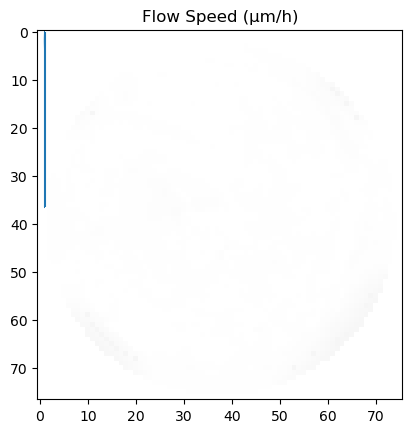

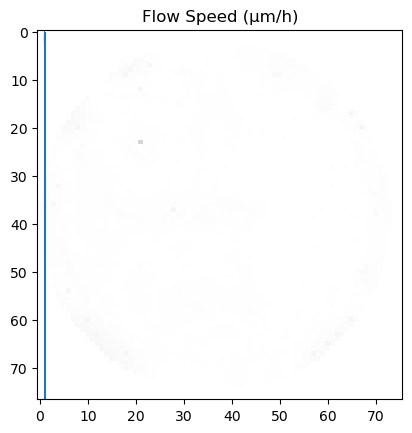

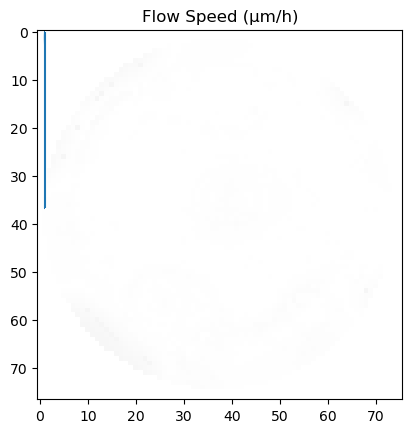

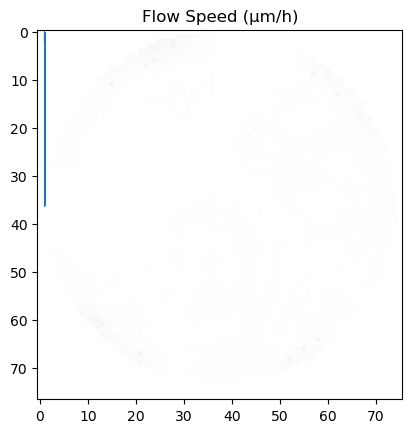

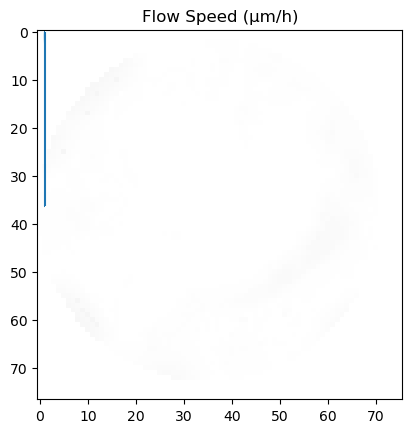

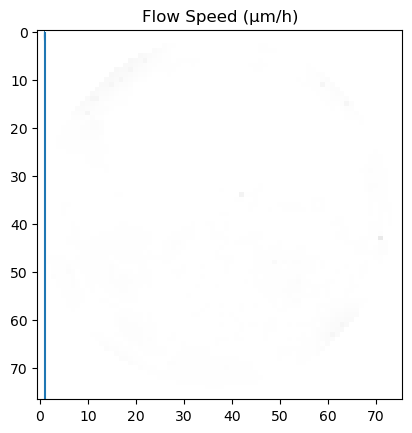

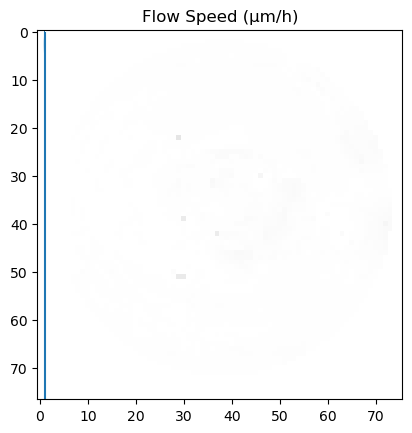

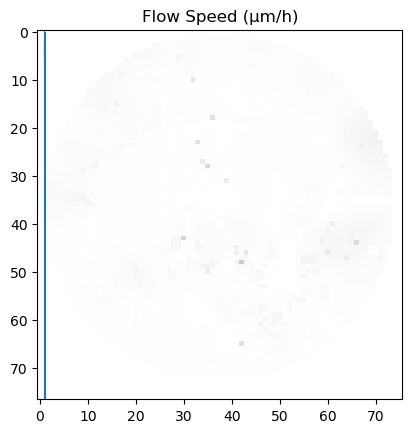

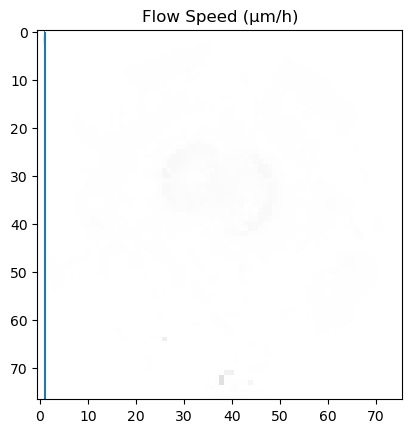

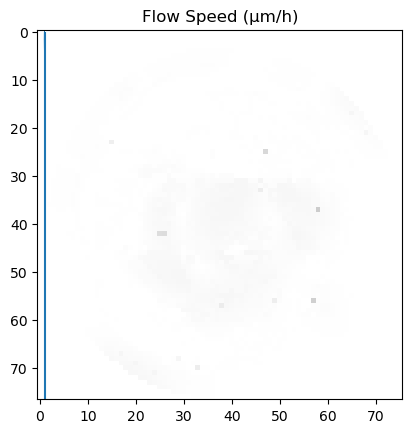

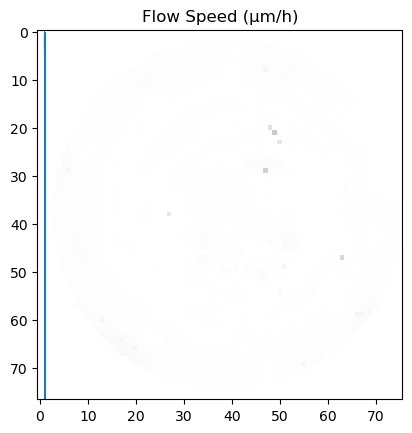

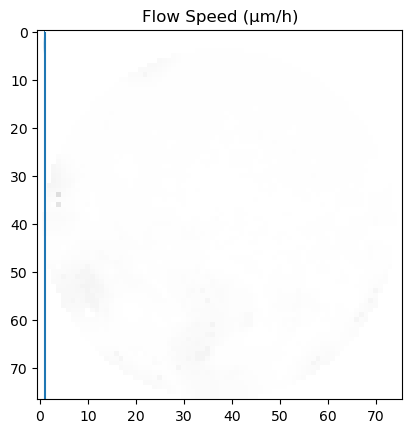

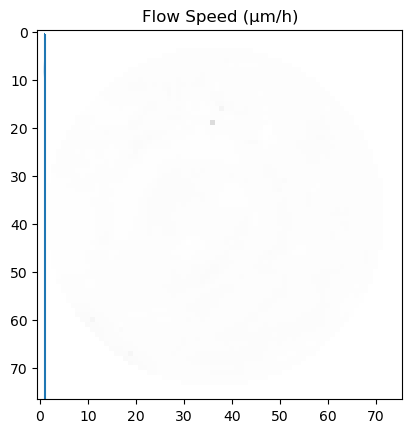

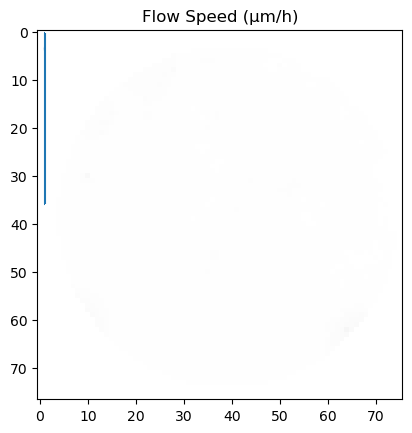

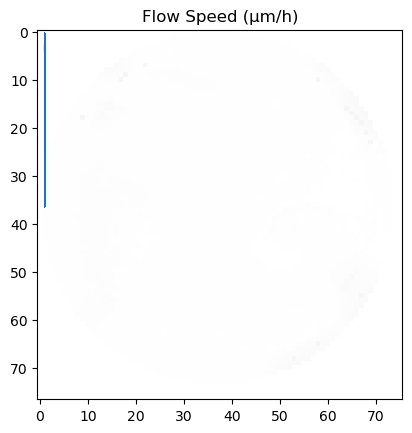

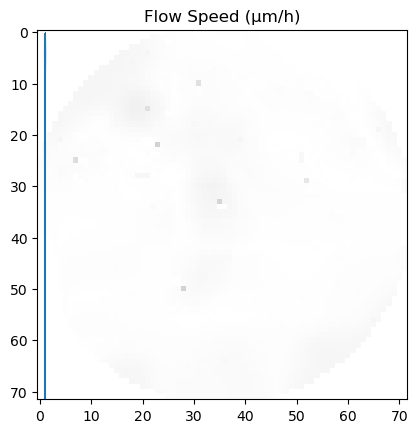

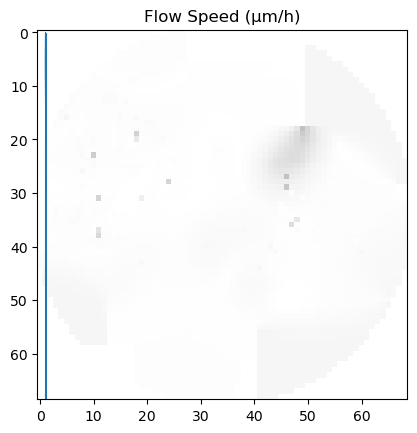

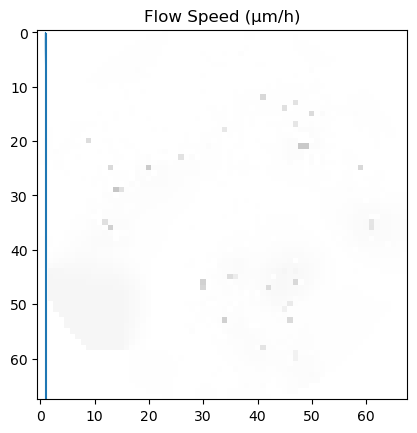

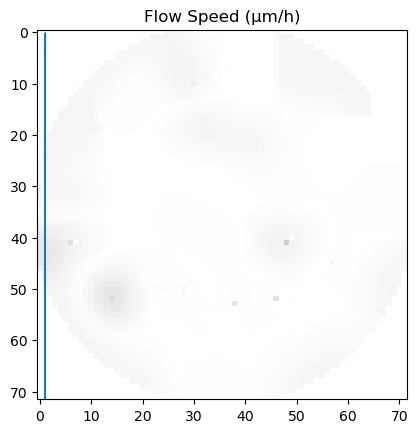

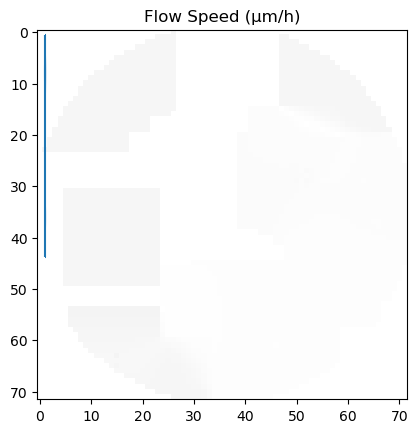

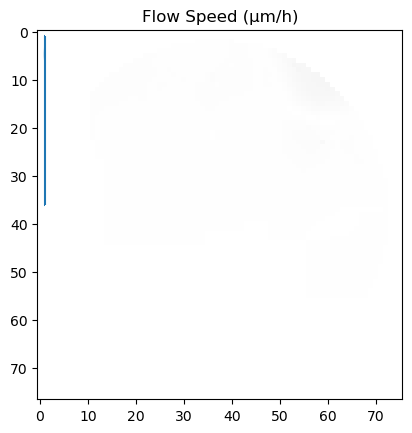

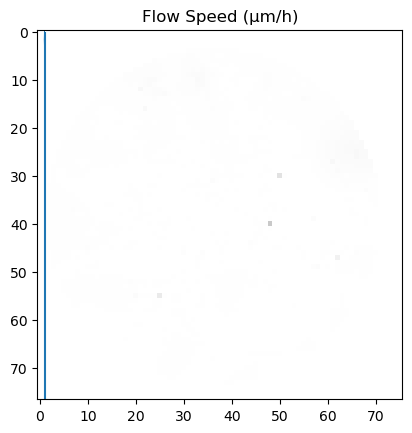

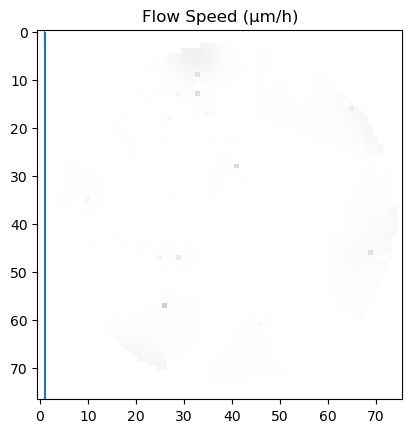

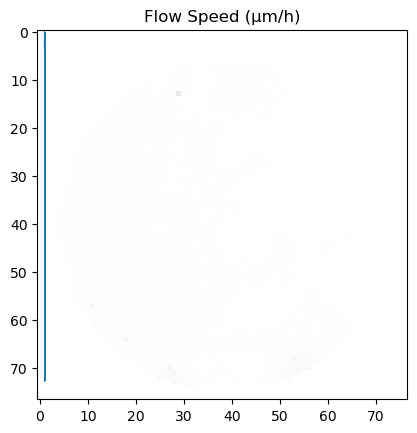

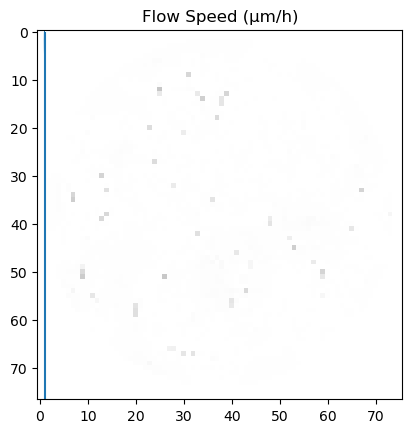

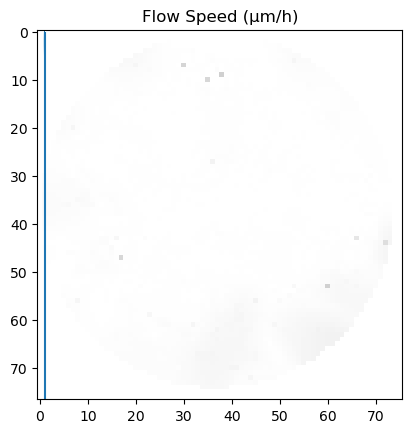

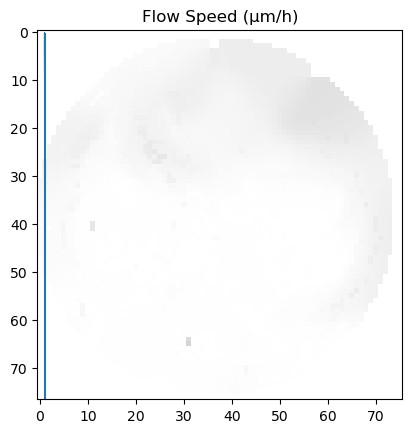

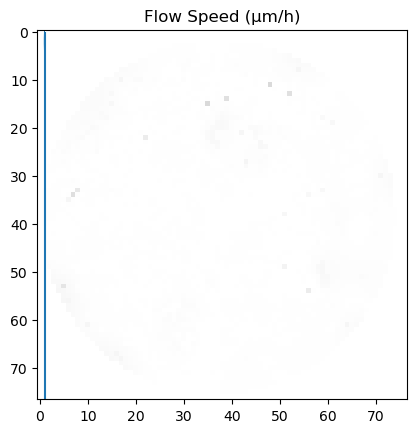

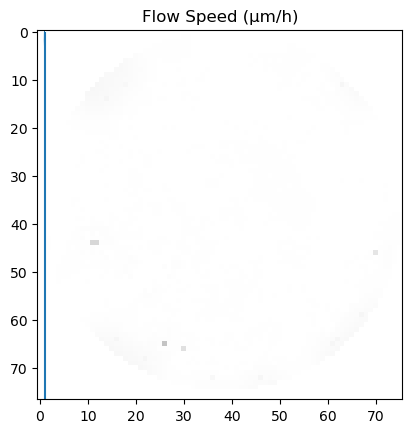

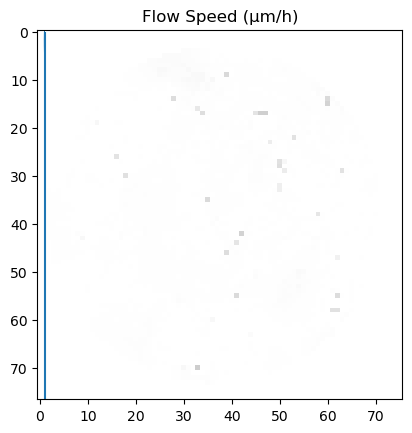

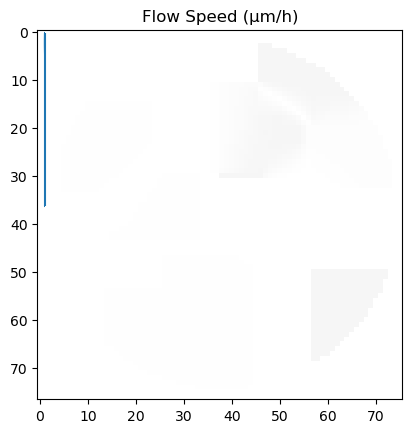

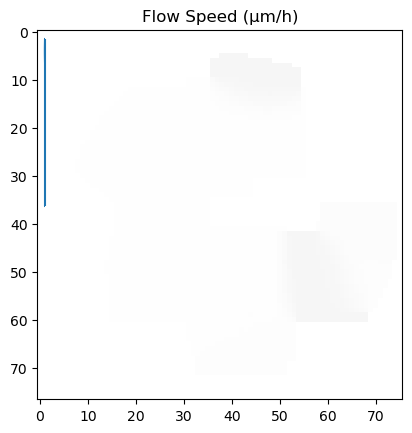

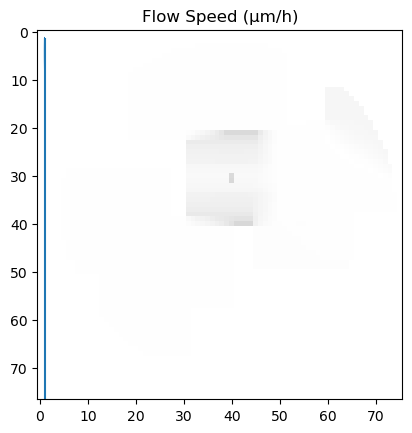

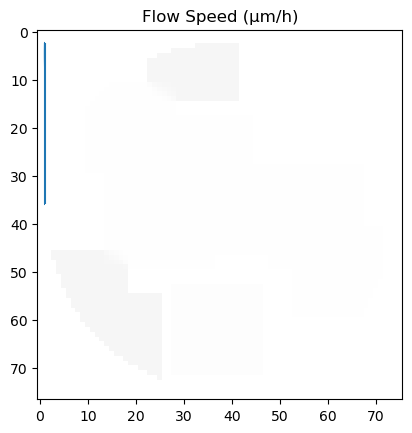

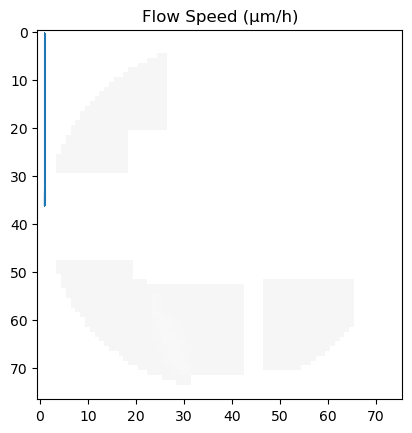

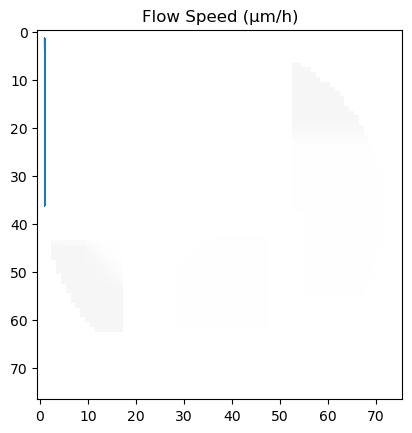

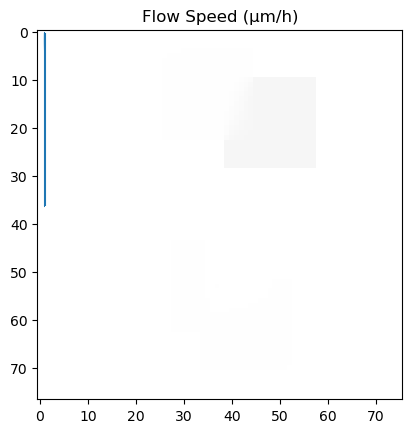

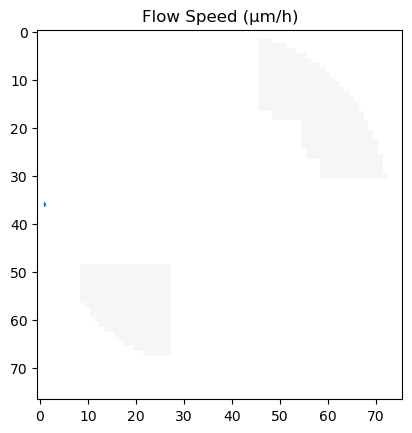

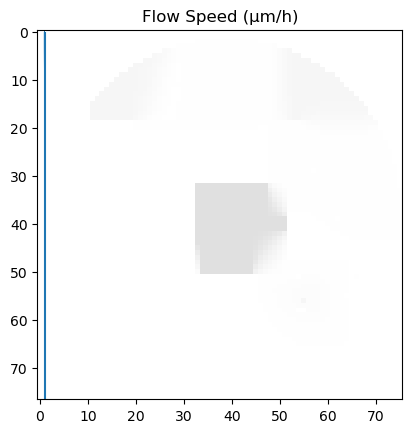

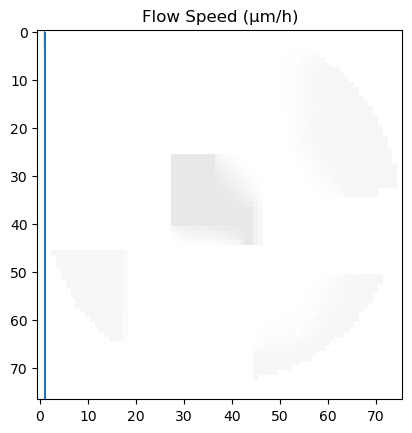

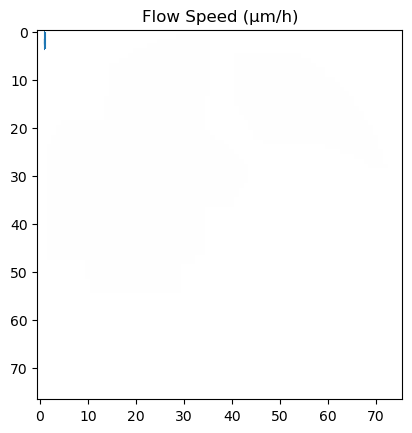

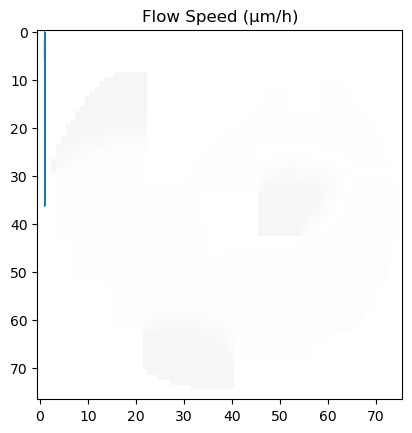

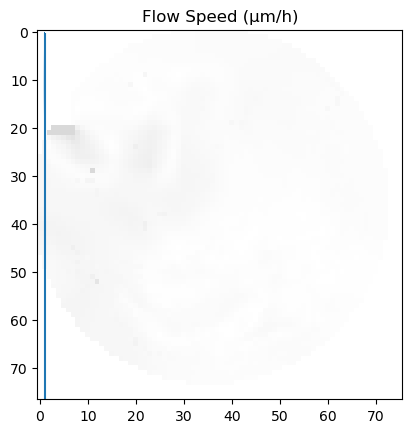

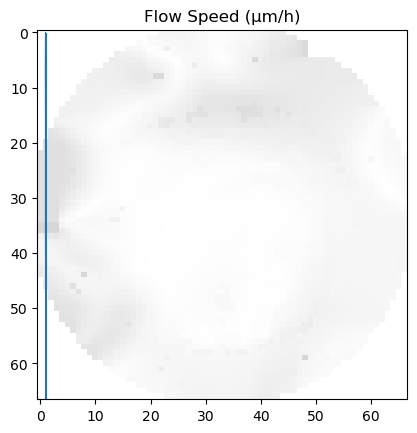

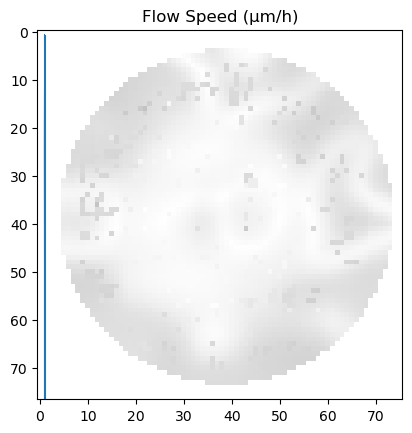

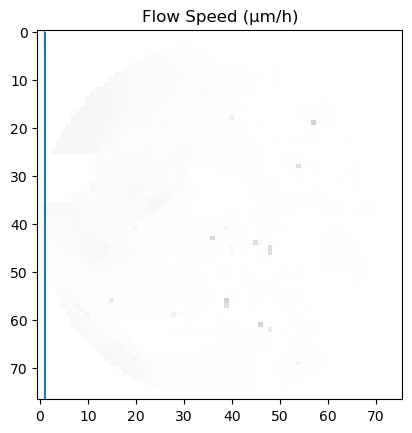

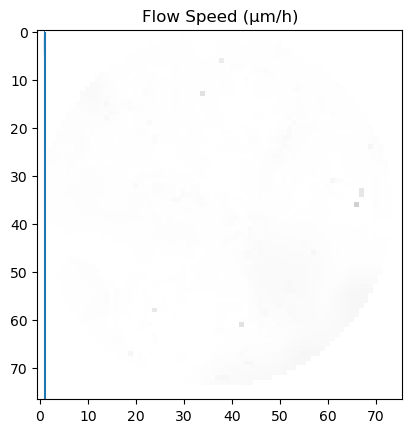

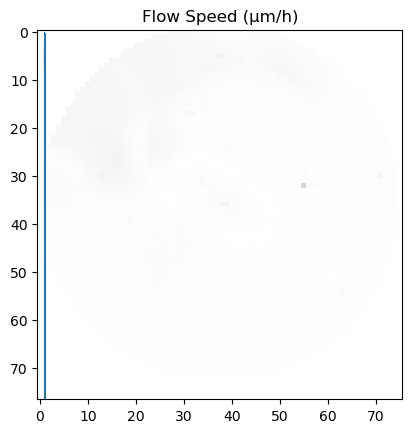

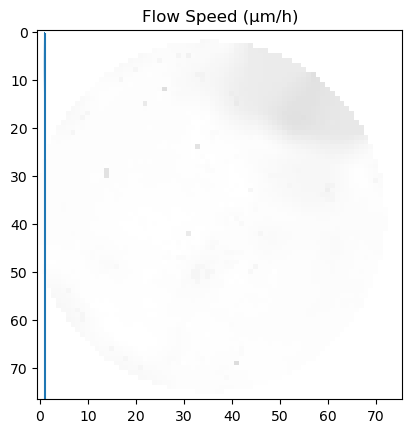

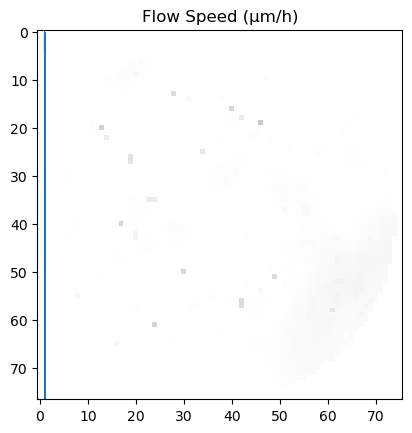

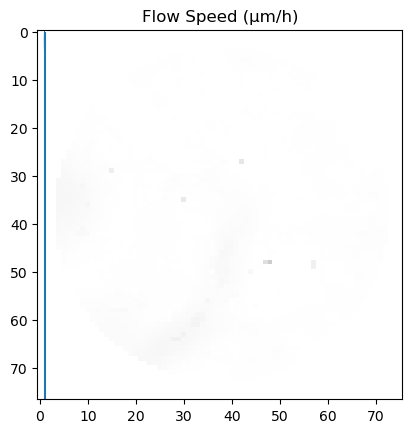

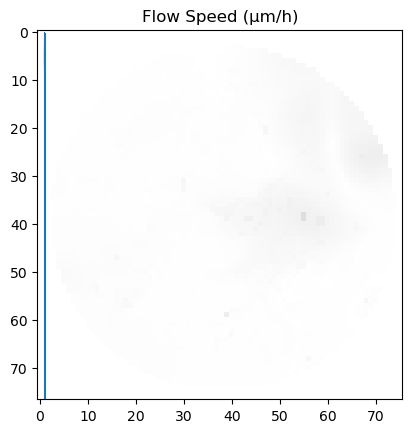

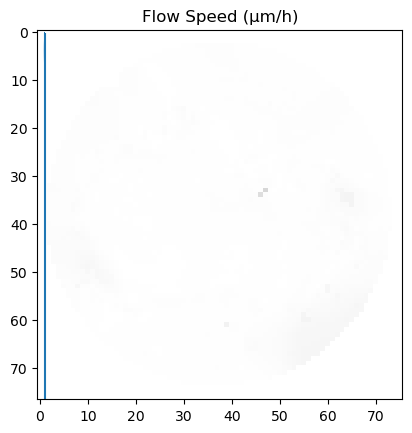

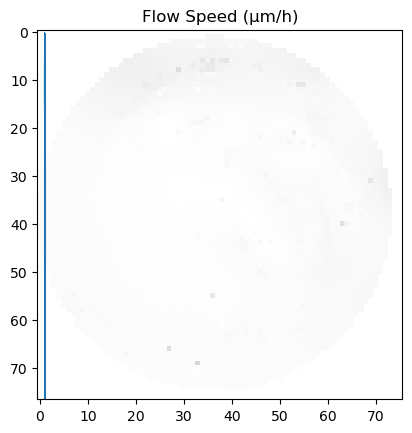

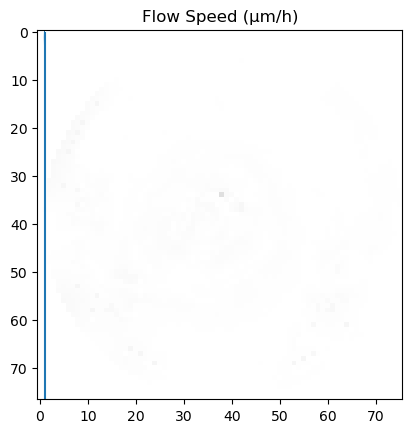

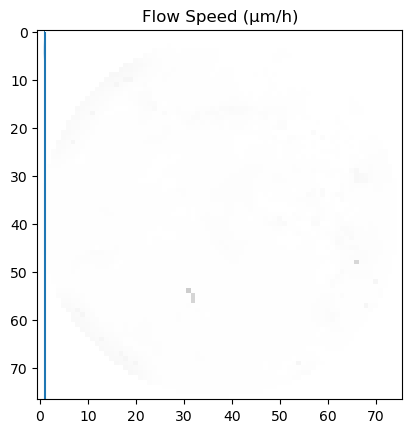

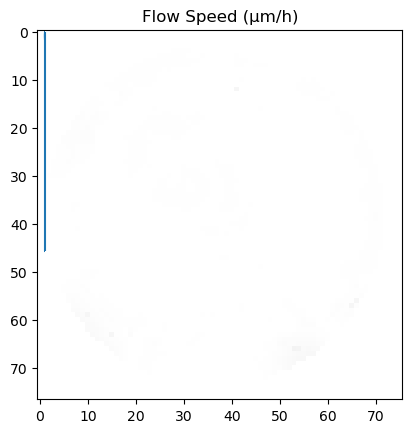

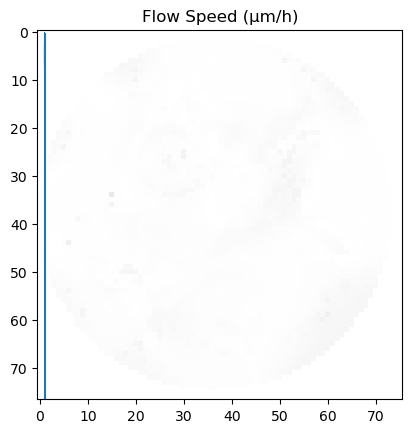

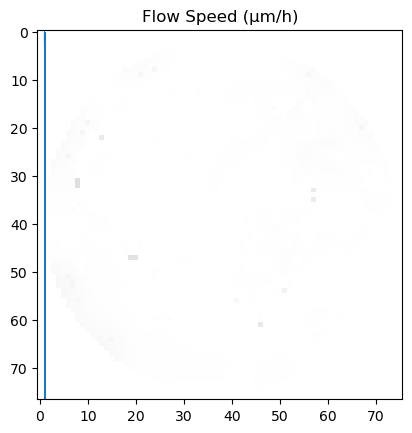

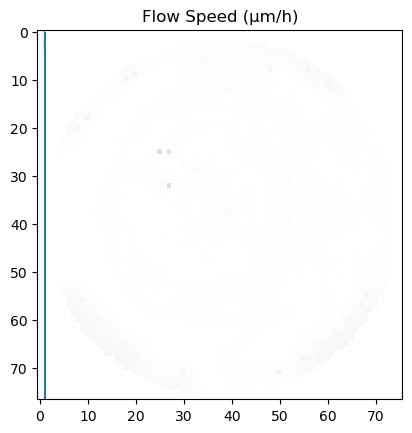

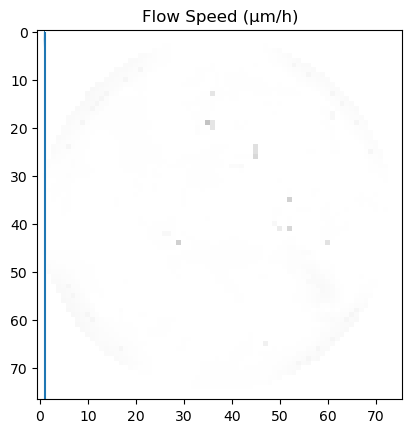

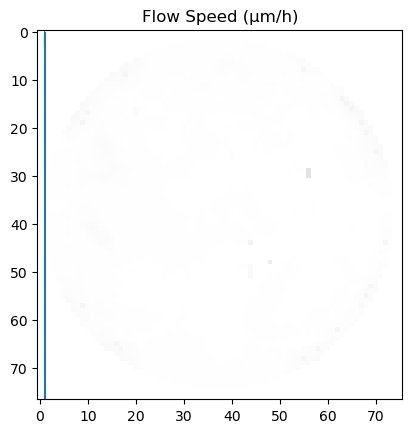

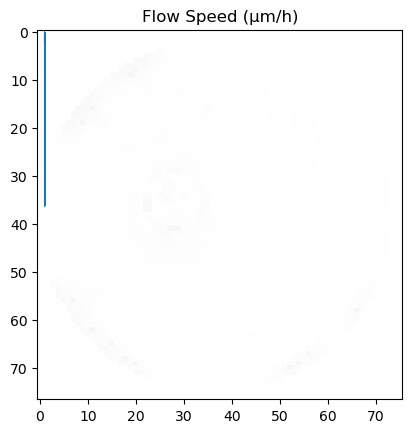

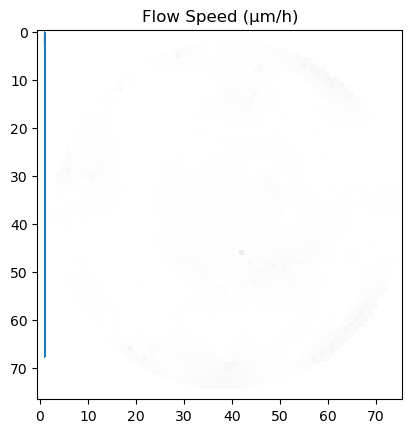

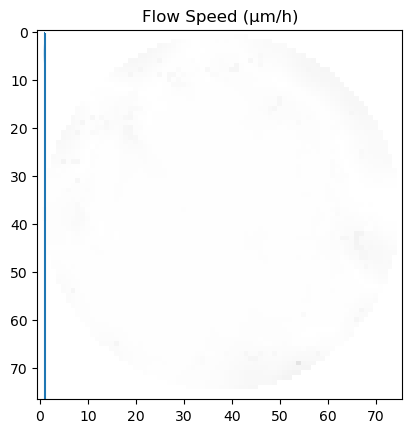

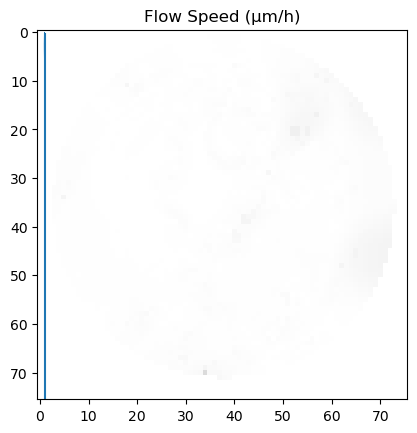

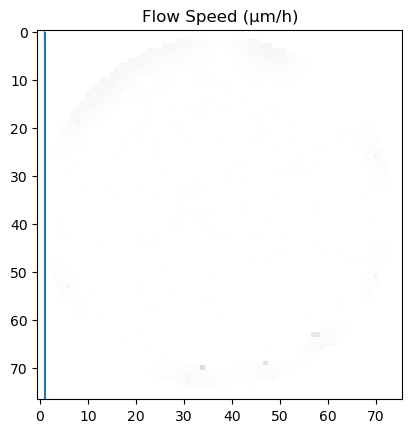

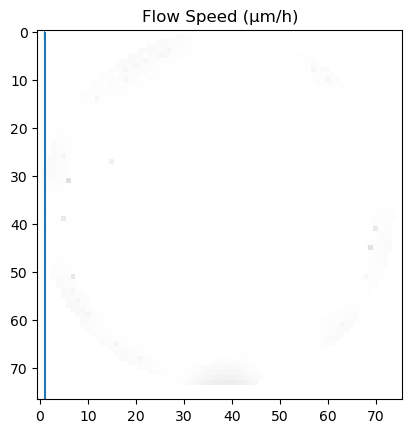

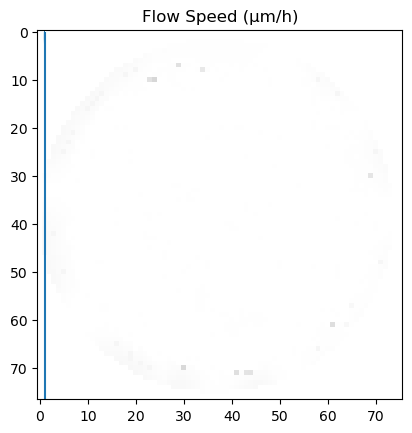

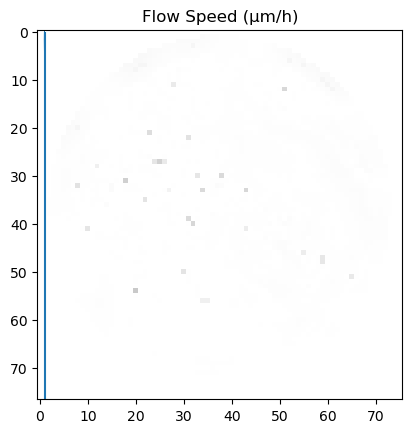

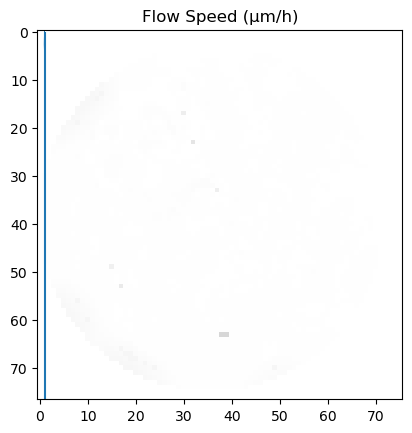

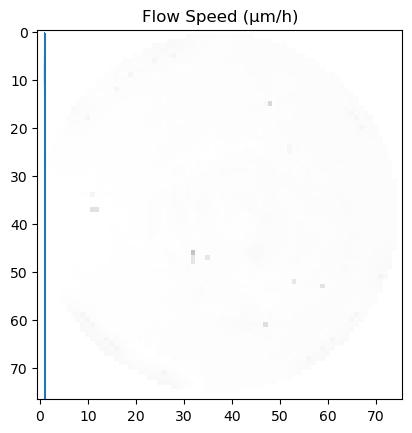

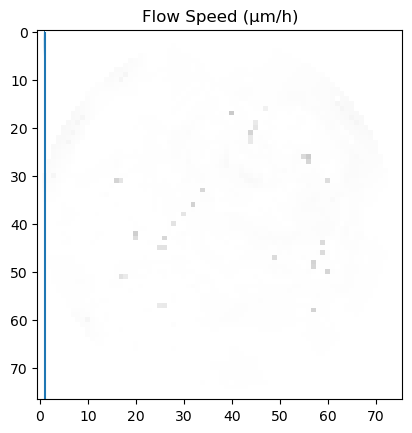

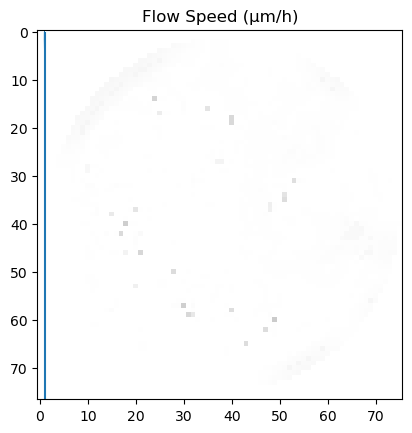

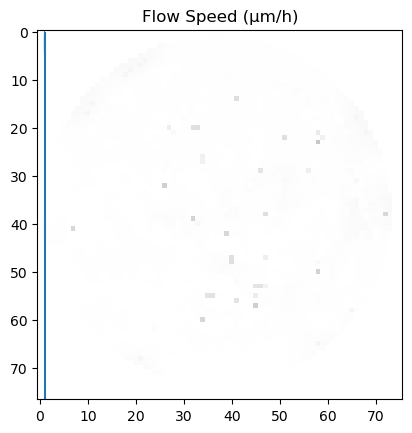

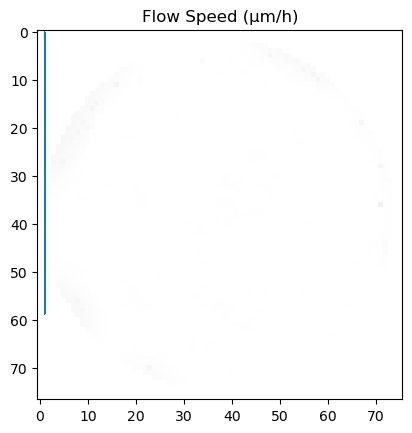

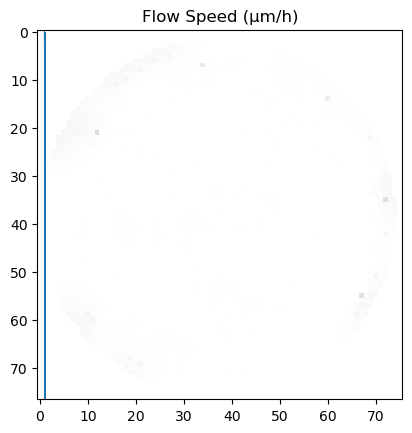

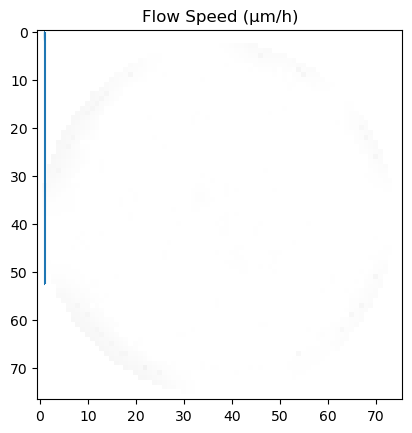

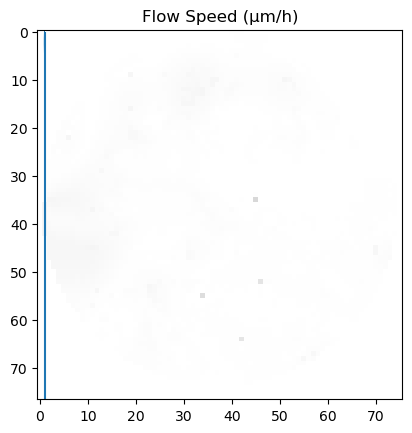

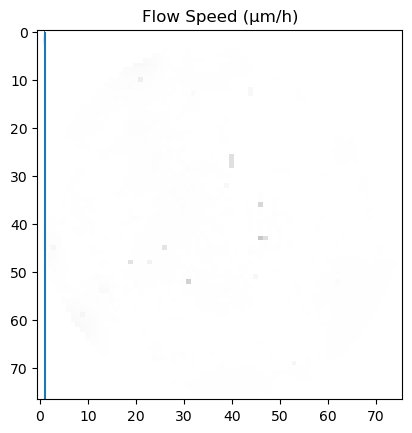

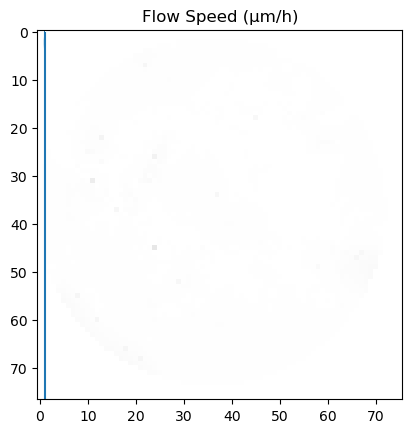

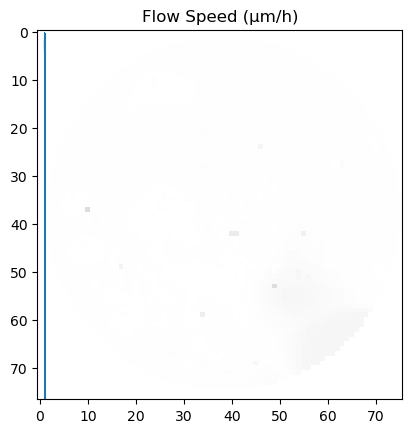

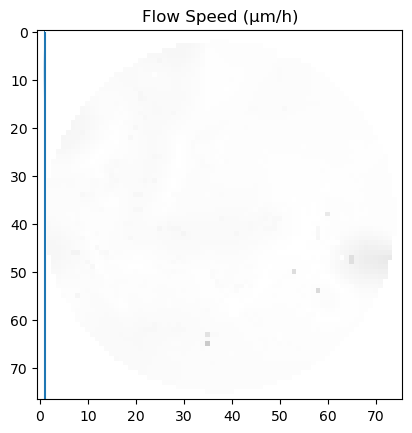

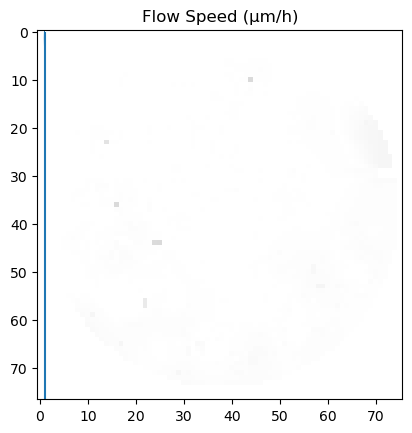

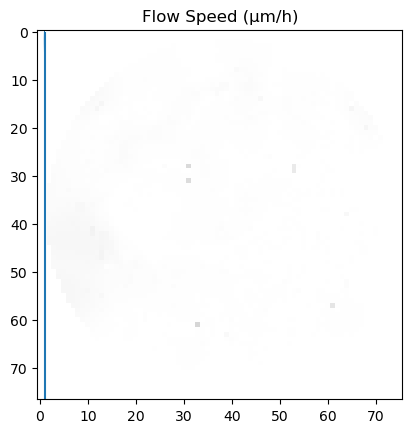

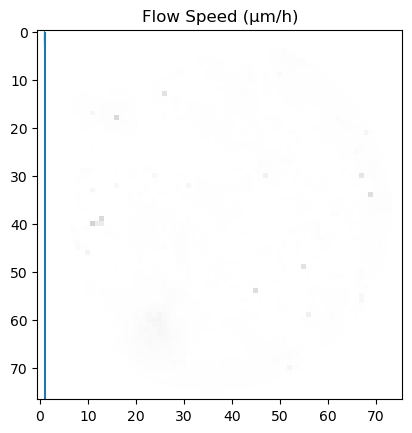

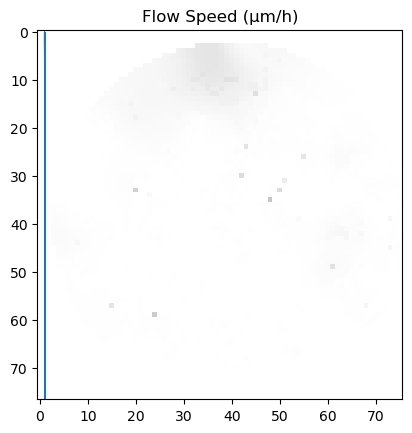

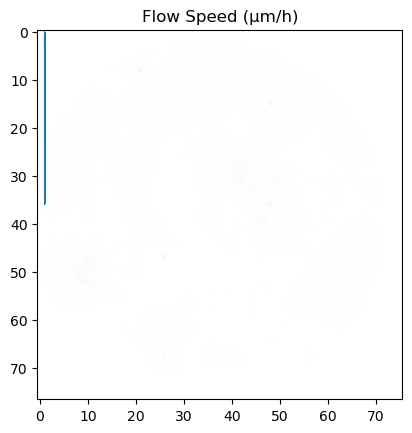

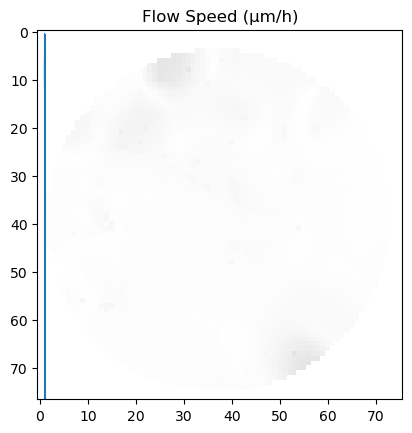

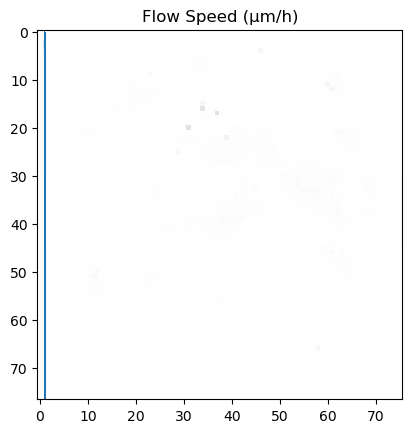

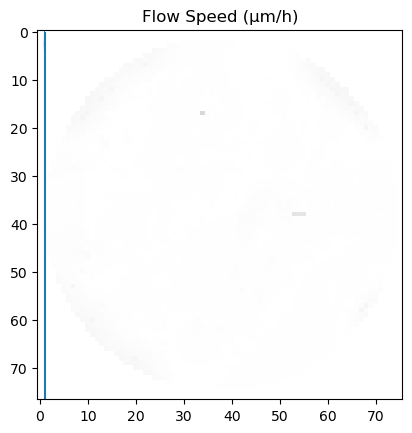

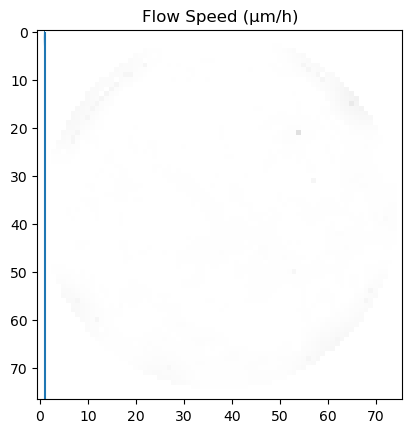

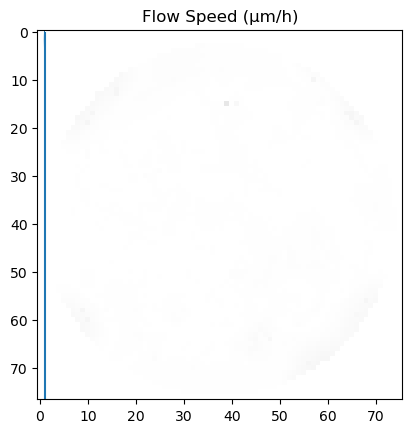

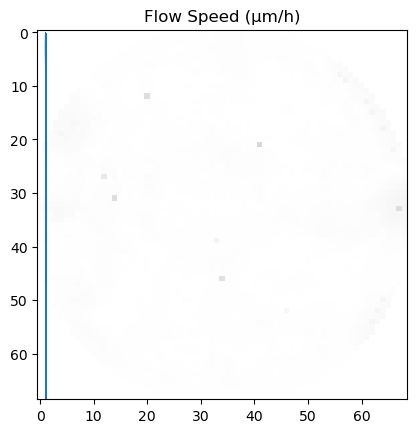

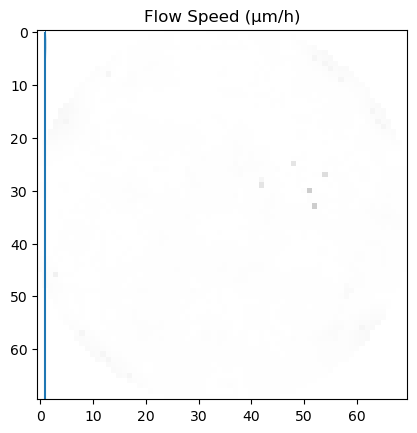

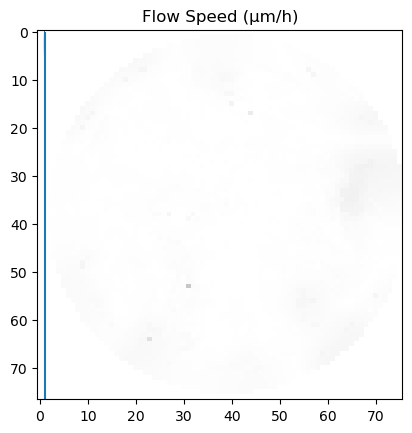

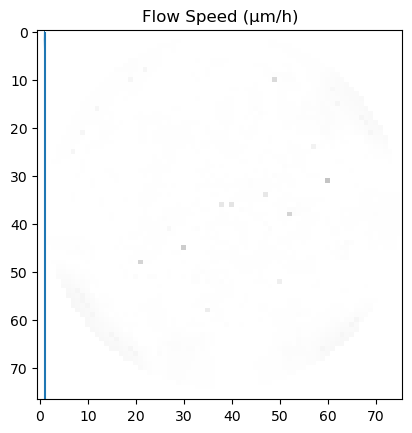

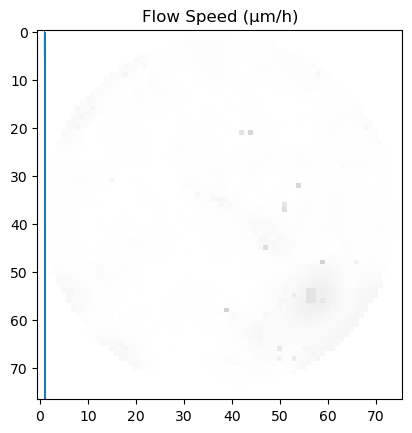

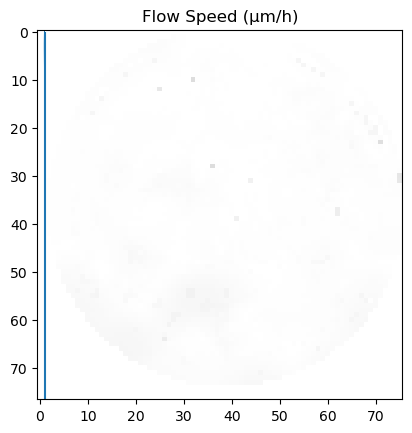

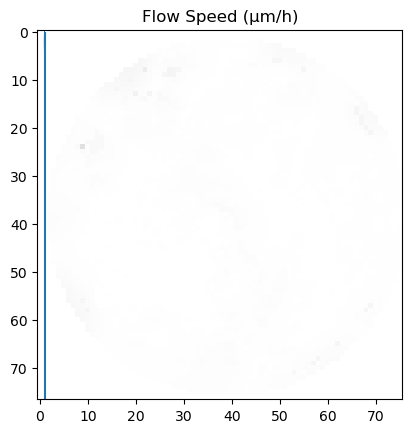

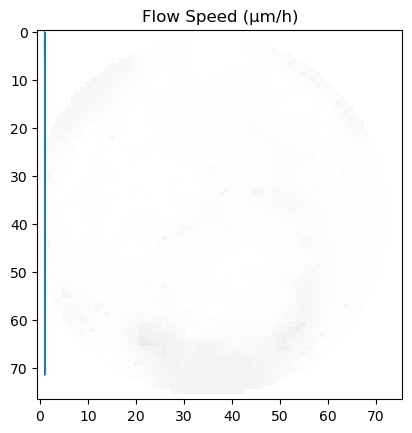

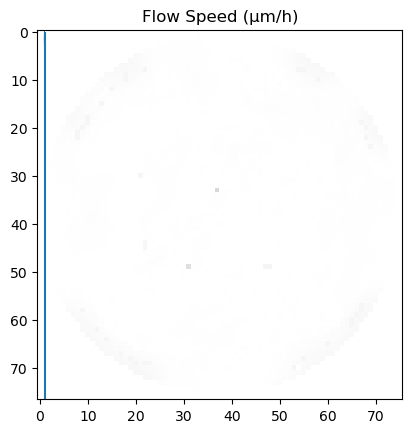

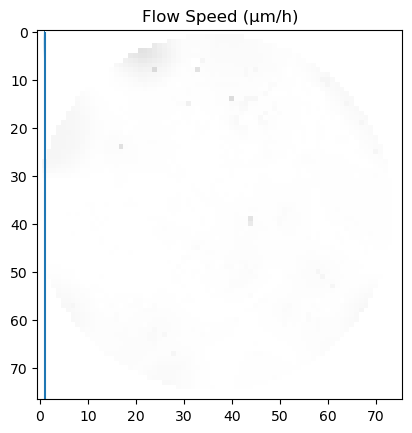

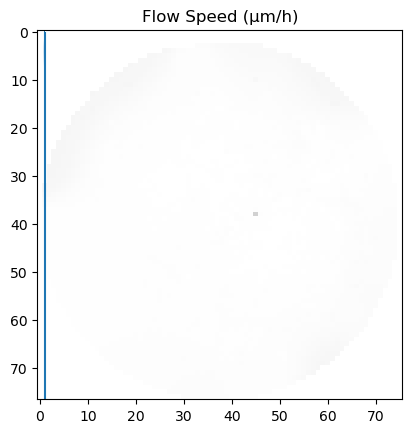

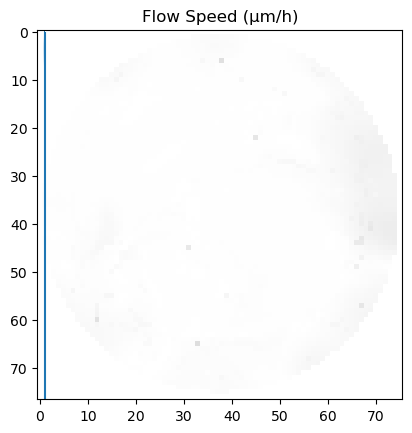

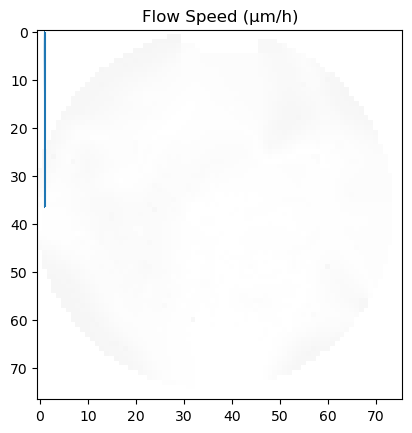

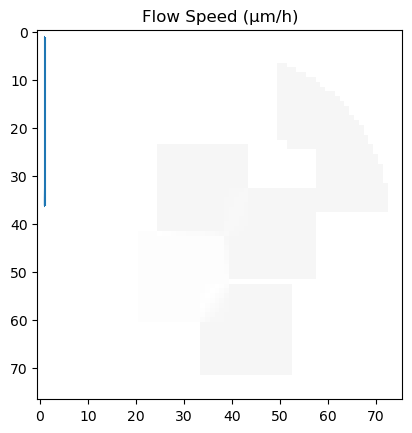

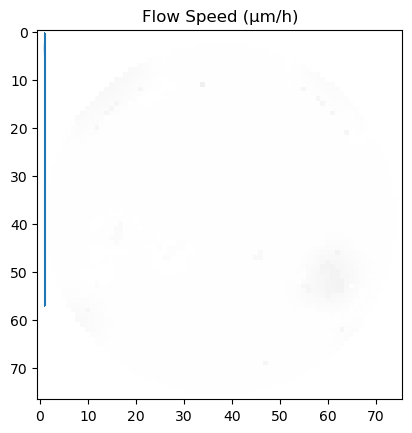

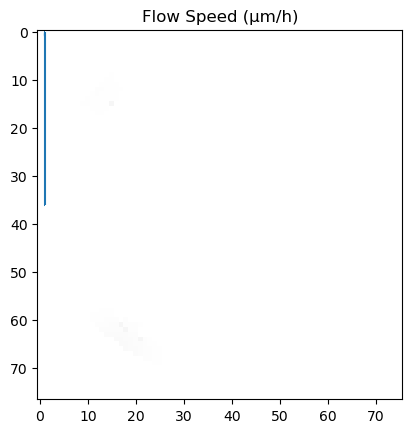

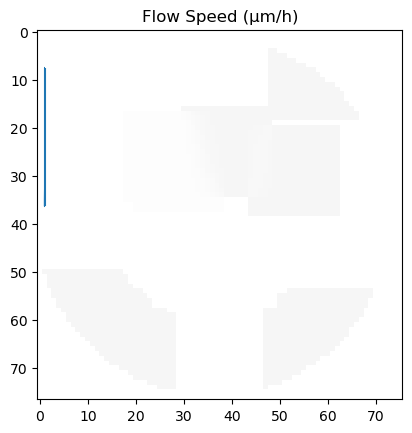

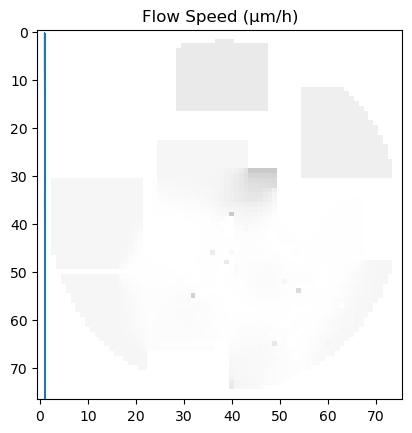

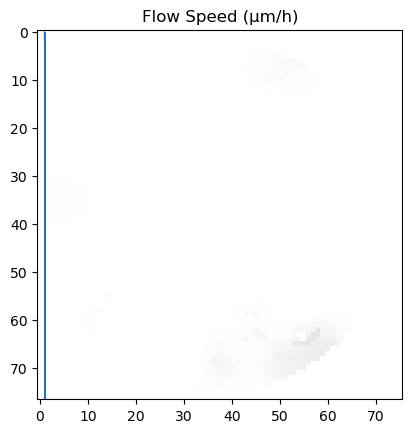

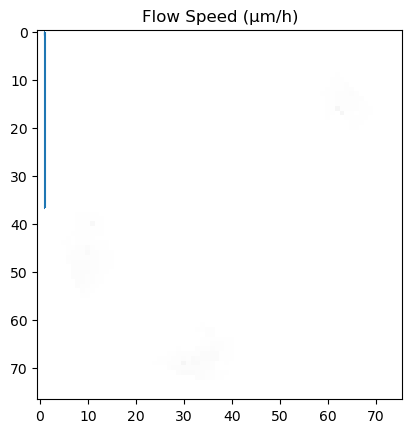

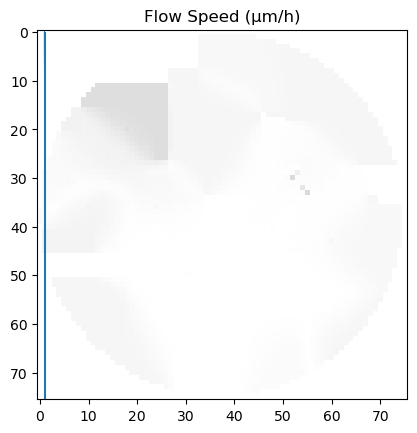

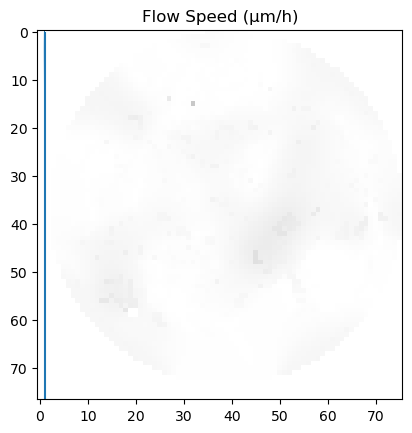

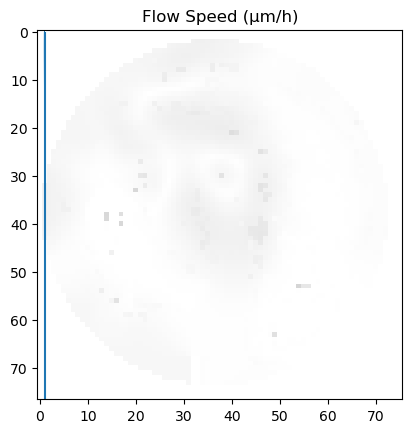

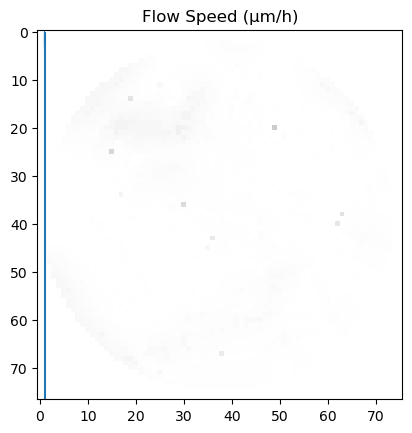

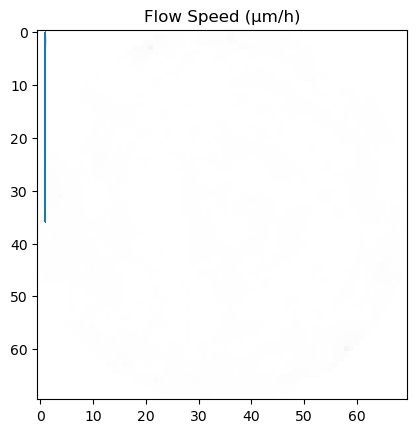

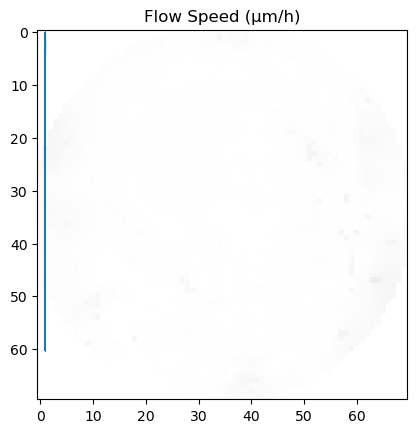

In [4]:
# usage example
folder = 'D:/0_all_whole/spynuc/continual2/'
pivit(folder)
